# Financial data
https://www.kaggle.com/datasets/leukipp/reddit-finance-data/data


https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
https://blog.tensorflow.org/2023/09/forecasting-with-tensorflow-decision-forests-and-temporian.html

https://www.tensorflow.org/decision_forests


In [1]:
import os
import emoji
from collections import Counter
import pandas as pd
import seaborn as sns
import math
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split


2024-07-14 12:30:54.342037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [144]:
pd.set_option('display.max_colwidth', 100) 

In [36]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

In [96]:
link = '/data/wallstreetbets/submissions_reddit.csv'
df_orig = pd.read_csv(os.getcwd()+link)

In [97]:
nlp_cols = ['created','selftext']

In [98]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775326 entries, 0 to 775325
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     775326 non-null  object 
 1   author                 775326 non-null  object 
 2   created                775326 non-null  object 
 3   retrieved              775326 non-null  object 
 4   edited                 775326 non-null  object 
 5   pinned                 775326 non-null  int64  
 6   archived               775326 non-null  int64  
 7   locked                 775326 non-null  int64  
 8   removed                775326 non-null  int64  
 9   deleted                775326 non-null  int64  
 10  is_self                775326 non-null  int64  
 11  is_video               775326 non-null  int64  
 12  is_original_content    775326 non-null  int64  
 13  title                  775322 non-null  object 
 14  link_flair_text        762000 non-nu

In [99]:
df_orig.head()

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko124i,[deleted],2021-01-01 00:02:06,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,34,0,1,14,0,[deleted],default,https://redd.it/ko124i
1,ko12uq,[deleted],2021-01-01 00:03:20,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,2,0,0,0,0,[deleted],default,https://redd.it/ko12uq
2,ko13df,[deleted],2021-01-01 00:04:11,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Meme,0.88,13,0,0,7,0,[deleted],default,https://redd.it/ko13df
3,ko17yf,shirotimatim,2021-01-01 00:11:51,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,News,0.92,183,0,0,26,0,NaN,https://b.thumbs.redditmedia.com/LmWdNB0W1qHT0...,https://redd.it/ko17yf
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.50,0,0,0,19,0,Every time a new submission is posted to walls...,self,https://redd.it/ko1a4i


In [269]:
df_orig['selftext'].str.slice(0,25).value_counts().iloc[:25]

selftext
[removed]                        389757
[deleted]                         89662
&#x200B;\n\nhttps://preview         550
Your daily trading discus           466
Inductions\n------\n\n\n-----        76
What are your moves tomor            70
\nYour daily hype thread.            55
Your weekend discussion t            48
This is not financial adv            44
#Good morning traders and            34
# Welcome to WSB!\n\n\---\n\n        33
[https://www.youtube.com/            22
\nYour daily hype and or c           20
**Historical Post Earning            20
 How many total open inte            17
I am not a financial advi            16
[https://finance.yahoo.co            15
https://finance.yahoo.com            14
This post is in continuat            14
Every time a new submissi            14
Title                                13
Welcome to today's editio            10
&#x200B;\n\nhttps://i.redd.           9
https://www.reddit.com/r/             9
[https://www.marketwatch.      

In [123]:
# some posts are very common, such as weekly discussion threads. Remove anything that's been reposted more than 5 times.
unique_post_counts = df_orig[~df_orig['selftext'].isin(bad_posts)]['selftext'].value_counts().reset_index()
unique_post_counts['count'].value_counts()

count
1     32869
2       108
3        22
4        10
5         5
7         4
8         3
13        2
54        2
6         2
20        2
9         2
14        2
10        1
12        1
83        1
69        1
16        1
17        1
19        1
25        1
33        1
34        1
52        1
53        1
55        1
15        1
Name: count, dtype: int64

In [127]:
unique_post_counts[unique_post_counts['count']<2]

,selftext,count
178,Motherfuckers. I’ve figured it out. I’ve lost ...,1
179,Edit: this is an automated process Limit Up Li...,1
180,# ROMANCE OF THE THREE KINGDOMS\n\n💎🚀🌕\n\n\nHi...,1
181,"So, I keep running scenarios through my head. ...",1
182,Title says it all. See link.\n\n[https://www.f...,1
...,...,...
33042,Fidelity apparently doesnt engage in PFOF kick...,1
33043,Charles Schwab\n\nStash Banking\n\nRobin Hood\...,1
33044,"This is unnaceptable, we need to raise the step",1
33045,I need to join but it seems impossible to find...,1


In [176]:
df_orig['selftext']

0                                                                                                   [deleted]
1                                                                                                   [deleted]
2                                                                                                   [deleted]
3                                                                                                         NaN
4         Every time a new submission is posted to wallstreetbets /u/wsbvotebot posts a comment that allow...
                                                         ...                                                 
775321                                                                                              [removed]
775322                                                                                              [removed]
775323                                                                                                    NaN
775324    

In [177]:
df_orig.dropna(subset=['selftext'])

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko124i,[deleted],2021-01-01 00:02:06,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,34,0,1,14,0,[deleted],default,https://redd.it/ko124i
1,ko12uq,[deleted],2021-01-01 00:03:20,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,2,0,0,0,0,[deleted],default,https://redd.it/ko12uq
2,ko13df,[deleted],2021-01-01 00:04:11,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Meme,0.88,13,0,0,7,0,[deleted],default,https://redd.it/ko13df
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.50,0,0,0,19,0,Every time a new submission is posted to wallstreetbets /u/wsbvotebot posts a comment that allow...,self,https://redd.it/ko1a4i
5,ko1bnp,dluther93,2021-01-01 00:18:03,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,0,...,Discussion,1.00,1,0,0,0,0,[removed],default,https://redd.it/ko1bnp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775320,rt6bf1,Jacobsen0007,2021-12-31 23:40:12,2022-01-01 03:56:58,1970-01-01 00:00:00,0,0,0,1,0,...,Shitpost,1.00,1,0,0,0,0,[removed],nsfw,https://redd.it/rt6bf1
775321,rt6e7q,[deleted],2021-12-31 23:44:10,2022-01-01 03:56:58,1970-01-01 00:00:00,0,0,0,1,0,...,Discussion,1.00,1,0,0,1,0,[removed],default,https://redd.it/rt6e7q
775322,rt6frk,Hychro617,2021-12-31 23:46:35,2022-01-01 03:56:58,1970-01-01 00:00:00,0,0,0,1,0,...,YOLO,1.00,1,0,0,1,0,[removed],self,https://redd.it/rt6frk
775324,rt6kvg,[deleted],2021-12-31 23:54:17,2022-01-01 03:56:58,1970-01-01 00:00:00,0,0,0,1,1,...,Discussion,1.00,1,0,0,1,0,[deleted],default,https://redd.it/rt6kvg


In [236]:
df_orig.isna().sum()

id                            0
author                        0
created                       0
retrieved                     0
edited                        0
pinned                        0
archived                      0
locked                        0
removed                       0
deleted                       0
is_self                       0
is_video                      0
is_original_content           0
title                         4
link_flair_text           13326
upvote_ratio                  0
score                         0
gilded                        0
total_awards_received         0
num_comments                  0
num_crossposts                0
selftext                 261914
thumbnail                     0
shortlink                     0
dtype: int64

## What do discussion threads look like?

These posts can be removed since the titles don't offer anything

In [157]:
df_orig[(df_orig['link_flair_text']=='Daily Discussion')]['selftext'].str.slice(0,100).value_counts().iloc[:25]

selftext
Your daily trading discussion thread. Please keep the shitposting to a minimum. \n\n^Navigate ^WSB|^We               238
Your daily trading discussion thread. Please keep the shitposting to a minimum. \n\n^Navigate ^WSB |^W               171
What are your moves tomorrow? Please keep the shitposting at a slow boil. \n\n^Navigate ^WSB|^We ^reco                68
Inductions\n------\n\n\n----------\nUser|Cast Vote|Voters\n:--|:--|:--\n**None**\n\nEjections\n------\n\n\n------     53
[removed]                                                                                                              9
[deleted]                                                                                                              2
Inductions\n------\n\n\n----------\nUser|Cast Vote|Voters\n:--|:--|:--\n/u/nrdrage|[Cast Vote](https://www.            2
CLOV, BB, and CLNE discussion can be found in the [Popular Ticker Thread](https://www.reddit.com/r/w                   2
Today's [Popular Ticker

## Final cleaning

In [168]:
df_orig.iloc[:5]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko124i,[deleted],2021-01-01 00:02:06,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,34,0,1,14,0,[deleted],default,https://redd.it/ko124i
1,ko12uq,[deleted],2021-01-01 00:03:20,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Gain,1.00,2,0,0,0,0,[deleted],default,https://redd.it/ko12uq
2,ko13df,[deleted],2021-01-01 00:04:11,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,1,1,...,Meme,0.88,13,0,0,7,0,[deleted],default,https://redd.it/ko13df
3,ko17yf,shirotimatim,2021-01-01 00:11:51,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,News,0.92,183,0,0,26,0,NaN,https://b.thumbs.redditmedia.com/LmWdNB0W1qHT01I3_5FUbCExoPd_kZ7-4CwkwIqlRzk.jpg,https://redd.it/ko17yf
4,ko1a4i,WSBVoteBot,2021-01-01 00:15:38,2021-02-02 21:52:13,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.50,0,0,0,19,0,Every time a new submission is posted to wallstreetbets /u/wsbvotebot posts a comment that allow...,self,https://redd.it/ko1a4i


In [231]:
df_orig.shape

(775326, 24)

In [232]:
def remove_records(df_orig):
    df = df_orig.copy()
    
    not_daily_discussion = (df_orig['link_flair_text']!='Daily Discussion')
    removed_posts=['[removed]', '[deleted]']
    not_removed_post = (~df_orig['selftext'].isin(removed_posts))
    
    df = df[not_daily_discussion]
    df = df[not_removed_post]
    
    df = df.dropna(subset=['selftext'])
    
    return df

In [233]:
df = remove_records(df_orig)

/tmp/ipykernel_220604/204822025.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[not_removed_post]


In [247]:
df['selftext'] = df['selftext'].apply(preprocessor).apply(cleaner)

In [248]:
df.shape

(33407, 24)

In [249]:
df.describe()

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
count,33407.0,33407.0,33407.000000,33407.0,33407.0,33407.0,33407.0,33407.000000,33407.000000,33407.000000,33407.000000,33407.000000,33407.000000,33407.000000
mean,0.0,0.0,0.000599,0.0,0.0,1.0,0.0,0.027569,0.777134,394.869848,0.123537,4.098632,153.376418,0.184722
std,0.0,0.0,0.024461,0.0,0.0,0.0,0.0,0.163737,0.188680,3407.198360,1.148694,37.594240,2110.230478,1.145666
min,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.670000,7.000000,0.000000,0.000000,5.000000,0.000000
50%,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.820000,22.000000,0.000000,0.000000,15.000000,0.000000
75%,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.930000,74.000000,0.000000,1.000000,43.000000,0.000000
max,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,1.000000,1.000000,216828.000000,118.000000,2756.000000,96694.000000,57.000000


In [7]:
df_orig.isna().sum()

id                            0
author                        0
created                       0
retrieved                     0
edited                        0
pinned                        0
archived                      0
locked                        0
removed                       0
deleted                       0
is_self                       0
is_video                      0
is_original_content           0
title                         4
link_flair_text           13326
upvote_ratio                  0
score                         0
gilded                        0
total_awards_received         0
num_comments                  0
num_crossposts                0
selftext                 261914
thumbnail                     0
shortlink                     0
dtype: int64

(-0.5, 799.5, 399.5, -0.5)

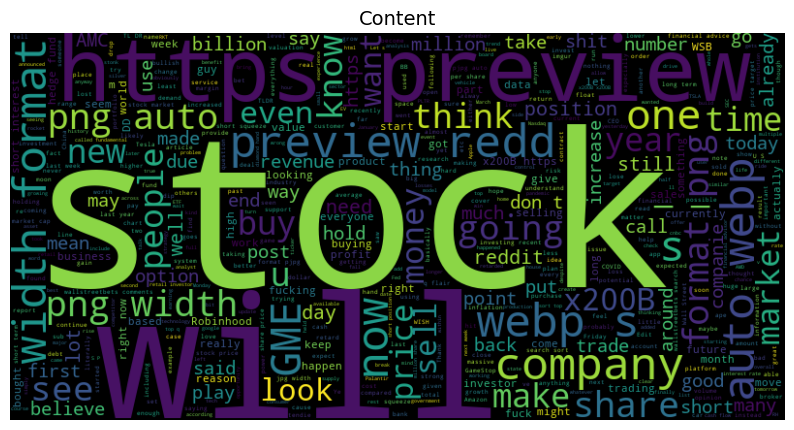

In [237]:
plt.figure(figsize=(10, 10))
words = " ".join(df.selftext)
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Content', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

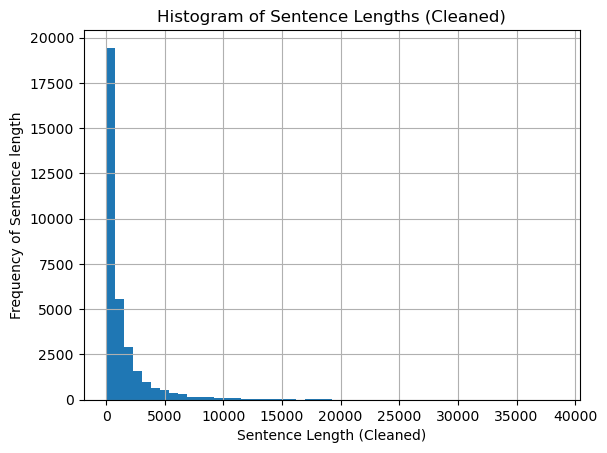

In [246]:
df['selftext'].apply(preprocessor).apply(cleaner).apply(len).hist(bins=50)
plt.title('Histogram of Sentence Lengths (Cleaned)')
plt.xlabel("Sentence Length (Cleaned)")
plt.ylabel("Frequency of Sentence length")
plt.show()

In [264]:
gme_keywords = ['gme', 'gamestop']
gme_posts = df.apply(lambda row: any(keyword in row['title'] or keyword in row['selftext'] for keyword in gme_keywords), axis=1)
# df.apply(lambda row: any(keyword in row['title'] or keyword in row['selftext'] for keyword in gme_keywords), axis=1)
gme_posts.sum()

10206

In [268]:
df[df['selftext'].str.contains('redd')]['selftext']

4         every time a new submission is posted to wallstreetbets u wsbvotebot posts a comment that allows...
41         x200b https preview redd it tpg1pco3gm861 png width 692 format png auto webp s 6e83f79e9aac4792...
44        alright earlier today i wrote an erotica novel of dd which was mainly a preface foreplay to this...
67        edit forgot to add my image like the true degenerate i am notable positions jan mostly tesla and...
90        edit big brain autists suggest this is option settlement makes sense to me wouldn t think much o...
                                                         ...                                                 
774891     overseas markets 1 u s stocks late dive dow down 0 25 to halt six game winning streak the three...
774982    over 8000 cals on gme could easily be in the money today there is some resistance at 160 but not...
775033    ive tried posting about this but it gets removed the fundementals are indicate an upwards price ...
775120    

# ML WORK

In [91]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
token_counts = Counter()
max_seq_length=None

In [92]:
tokenizer = Tokenizer(num_words=10, oov_token="<OOV>")
tokenizer.fit_on_texts(df_orig['Sentence_cleaned'])

sequences = tokenizer.texts_to_sequences(df_orig['Sentence_cleaned'])
word_index = tokenizer.word_index

In [93]:
## Step 2: find unique tokens (words)
from collections import Counter
tokenizer = tfds.features.text.Tokenizer()
token_counts = Counter()
for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
print('Vocab-size:', len(token_counts))

NameError: name 'tfds' is not defined

In [66]:
for example in df_orig:
    # tokens = tokenizer.tokenize(example[0].numpy()[0])
    tokens = tokenizer.sequences_to_texts(example[0].numpy()[0])
    if max_seq_length is not None:
        tokens = tokens[-max_seq_length:]
    token_counts.update(tokens)
print('Vocab-size:', len(token_counts))


AttributeError: 'str' object has no attribute 'numpy'